# ComplEx on WN18 and FB15K

This notebook reproduces the experiments done in the paper that introduced the ComplEx algorith: Complex Embeddings for Simple Link Prediction, Théo Trouillon, Johannes Welbl, Sebastian Riedel, Éric Gaussier and Guillaume Bouchard, ICML 2016. http://jmlr.org/proceedings/papers/v48/trouillon16.pdf

In table 2, the paper reports five metrics measured on the WN18 and FB15K datasets: "raw" MRR (mean reciprocal rank), "filtered" MRR and filtered Hits at {1, 3, 10}. This notebook measures only the "raw" metrics, because the filtered ones are currently more difficult to compute.

In [1]:
from stellargraph import datasets, utils
from tensorflow.keras import optimizers, losses, metrics, regularizers, Model
import numpy as np
import pandas as pd

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import ComplEx

from IPython.display import HTML

## Initialisation

We need to set up our model parameters, like the number of epochs to train for, and the dimension of the embedding vectors we compute for each node and for each edge type. We'll also define a function to do our evaluation, so we can easily apply it to both WN18 and FB15k.

The evaluation is performed in three steps:

1. Load the data
2. Train a model
3. Evaluate the model

The paper describes using the AdaGrad optimiser for 1000 epochs with an early stopping criterion evaluated every 50 epochs. We've found using the Adam optimiser allows for much fewer epochs. The paper says that the best choices of embedding dimension are generally 150 or 200, with close results. The paper evaluated using 1, 2, 5 and 10 negative samples, and found that using 10 improved performance on FB15k noticably (comparing to 1), but did not make much difference on WN18.

In [2]:
epochs = 20
embedding_dimension = 150
negative_samples = 10

## WN18

The paper uses the WN18 and FB15k datasets for validation. These datasets are not good for evaluating algorithms because they contain "inverse relations", where `(s, r1, o)` implies `(o, r2, s)` for a pair of relation types `r1` and `r2` (for instance, `_hyponym` ("is more specific than") and `_hypernym` ("is more general than") in WN18), however, they work fine to demonstrate StellarGraph's functionality, and are appropriate to compare against the published results.

### Load the data

The dataset comes with a defined train, test and validation split, each consisting of subject, relation, object triples. We can load a `StellarGraph` object with all of the triples, as well as the individual splits as Pandas DataFrames, using the `load` method of the `WN18` dataset.

In [3]:
wn18 = datasets.WN18()
display(HTML(wn18.description))
wn18_g, wn18_train, wn18_test, wn18_valid = wn18.load()

In [4]:
print(wn18_g.info())

StellarDiGraph: Directed multigraph
 Nodes: 40943, Edges: 151442

 Node types:
  default: [40943]
    Features: none
    Edge types: default-_also_see->default, default-_derivationally_related_form->default, default-_has_part->default, default-_hypernym->default, default-_hyponym->default, ... (13 more)

 Edge types:
    default-_hyponym->default: [37221]
    default-_hypernym->default: [37221]
    default-_derivationally_related_form->default: [31867]
    default-_member_meronym->default: [7928]
    default-_member_holonym->default: [7928]
    default-_part_of->default: [5148]
    default-_has_part->default: [5142]
    default-_member_of_domain_topic->default: [3341]
    default-_synset_domain_topic_of->default: [3335]
    default-_instance_hyponym->default: [3150]
    default-_instance_hypernym->default: [3150]
    default-_also_see->default: [1396]
    default-_verb_group->default: [1220]
    default-_member_of_domain_region->default: [983]
    default-_synset_domain_region_of->defa

### Train a model

The ComplEx algorithm consists of some embedding layers and a scoring layer, but the `ComplEx` object means these details are invisible to us. The `ComplEx` model consumes "knowledge-graph triples", which can be produced in the appropriate format using `KGTripleGenerator`.

In [5]:
wn18_gen = KGTripleGenerator(
    wn18_g, batch_size=len(wn18_train) // 100  # ~100 batches per epoch
)

wn18_complex = ComplEx(
    wn18_gen, k=embedding_dimension, embeddings_regularizer=regularizers.l2(1e-7)
)

wn18_inp, wn18_out = wn18_complex.build()

wn18_model = Model(inputs=wn18_inp, outputs=wn18_out)

wn18_model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)],
)

Inputs for training are produced by calling the `KGTripleGenerator.flow` method, this takes a dataframe with `source`, `label` and `target` columns, where each row is a true edge in the knowledge graph.  The `negative_samples` parameter controls how many random edges are created for each positive edge to use as negative examples for training.

In [6]:
wn18_train_gen = wn18_gen.flow(
    wn18_train, negative_samples=negative_samples, shuffle=True
)
wn18_valid_gen = wn18_gen.flow(wn18_valid, negative_samples=negative_samples)

In [7]:
wn18_history = wn18_model.fit(
    wn18_train_gen, validation_data=wn18_valid_gen, epochs=epochs
)

Train for 101 steps, validate for 4 steps
Epoch 1/20
101/101 [==============================] - 21s 203ms/step - loss: 0.6961 - binary_accuracy: 0.4991 - val_loss: 0.6960 - val_binary_accuracy: 0.4991
Epoch 2/20
101/101 [==============================] - 19s 191ms/step - loss: 0.6958 - binary_accuracy: 0.5063 - val_loss: 0.6957 - val_binary_accuracy: 0.5024
Epoch 3/20
101/101 [==============================] - 20s 200ms/step - loss: 0.6955 - binary_accuracy: 0.5161 - val_loss: 0.6954 - val_binary_accuracy: 0.5062
Epoch 4/20
101/101 [==============================] - 20s 195ms/step - loss: 0.6951 - binary_accuracy: 0.5283 - val_loss: 0.6951 - val_binary_accuracy: 0.5190
Epoch 5/20
101/101 [==============================] - 19s 191ms/step - loss: 0.6947 - binary_accuracy: 0.5440 - val_loss: 0.6947 - val_binary_accuracy: 0.5353
Epoch 6/20
101/101 [==============================] - 19s 191ms/step - loss: 0.6935 - binary_accuracy: 0.6203 - val_loss: 0.6917 - val_binary_accuracy: 0.7401
Epoc

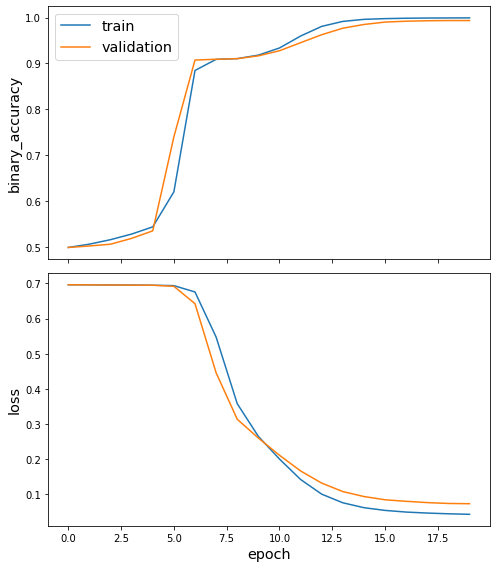

In [8]:
utils.plot_history(wn18_history)

### Evaluate the model

We've now trained a model, so we can apply the evaluation procedure from the paper to it. This is done by taking each test edge `E = (s, r, o)`, and scoring it against all mutations `(s, r, n)` and `(n, r, o)` for every node `n` in the graph, that is, doing a prediction for every one of these edges similar to `E`. The "raw" rank is the number of mutated edges that have a higher predicted score than the true `E`.

In [9]:
wn18_raw_ranks = ComplEx.rank_edges_against_all_nodes(
    wn18_model, wn18_gen.flow(wn18_test), wn18_g
)

In [10]:
# helper function to compute metrics from a dictionary of name -> array of ranks
def summarise(name_to_ranks):
    return pd.DataFrame(
        [
            {
                "mrr": np.mean(1 / ranks),
                "hits at 1": np.mean(ranks <= 1),
                "hits at 3": np.mean(ranks <= 3),
                "hits at 10": np.mean(ranks <= 10),
            }
            for ranks in name_to_ranks.values()
        ],
        index=name_to_ranks.keys(),
    )

In [11]:
summarise({"raw": wn18_raw_ranks})

,mrr,hits at 1,hits at 3,hits at 10
raw,0.571233,0.4501,0.6468,0.8026


For comparison, Table 2 in the paper gives the following results for WN18:

| raw MRR | filtered MRR | hits at 1 | hits at 3 | hits at 10 |
|--------:|-------------:|----------:|----------:|-----------:|
|   0.587 |        0.941 |     0.936 |     0.945 |      0.947 |

The raw MRR is similar.

## FB15k

Now that we know the process, we can apply the model on the FB15k dataset in the same way.

### Loading the data

In [12]:
fb15k = datasets.FB15k()
display(HTML(fb15k.description))
fb15k_g, fb15k_train, fb15k_test, fb15k_valid = fb15k.load()

In [13]:
print(fb15k_g.info())

StellarDiGraph: Directed multigraph
 Nodes: 14951, Edges: 592213

 Node types:
  default: [14951]
    Features: none
    Edge types: default-/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/position->default, default-/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/team->default, default-/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/coach->default, default-/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/team->default, default-/american_football/football_player/current_team./american_football/football_roster_position/position->default, ... (1340 more)

 Edge types:
    default-/award/award_nominee/award_nominations./award/award_nomination/award_nominee->default: [19764]
    default-/film/film/release_date_s./film/film_r

### Train a model

In [14]:
fb15k_gen = KGTripleGenerator(
    fb15k_g, batch_size=len(fb15k_train) // 100  # ~100 batches per epoch
)

fb15k_complex = ComplEx(
    fb15k_gen, k=embedding_dimension, embeddings_regularizer=regularizers.l2(1e-8)
)

fb15k_inp, fb15k_out = fb15k_complex.build()

fb15k_model = Model(inputs=fb15k_inp, outputs=fb15k_out)
fb15k_model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)],
)

In [15]:
fb15k_train_gen = fb15k_gen.flow(
    fb15k_train, negative_samples=negative_samples, shuffle=True
)
fb15k_valid_gen = fb15k_gen.flow(fb15k_valid, negative_samples=negative_samples)

In [16]:
fb15k_history = fb15k_model.fit(
    fb15k_train_gen, validation_data=fb15k_valid_gen, epochs=epochs
)

Train for 101 steps, validate for 11 steps
Epoch 1/20
101/101 [==============================] - 33s 324ms/step - loss: 0.6933 - binary_accuracy: 0.5003 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 2/20
101/101 [==============================] - 33s 327ms/step - loss: 0.6933 - binary_accuracy: 0.5032 - val_loss: 0.6933 - val_binary_accuracy: 0.5024
Epoch 3/20
101/101 [==============================] - 32s 320ms/step - loss: 0.6932 - binary_accuracy: 0.5097 - val_loss: 0.6932 - val_binary_accuracy: 0.5101
Epoch 4/20
101/101 [==============================] - 33s 324ms/step - loss: 0.6929 - binary_accuracy: 0.5434 - val_loss: 0.6919 - val_binary_accuracy: 0.6082
Epoch 5/20
101/101 [==============================] - 33s 330ms/step - loss: 0.6706 - binary_accuracy: 0.8121 - val_loss: 0.6084 - val_binary_accuracy: 0.9007
Epoch 6/20
101/101 [==============================] - 33s 324ms/step - loss: 0.4608 - binary_accuracy: 0.9076 - val_loss: 0.3359 - val_binary_accuracy: 0.9086
Epo

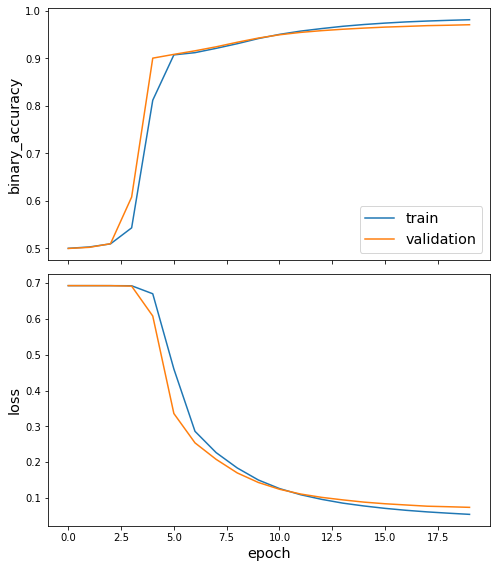

In [17]:
utils.plot_history(fb15k_history)

### Evaluate the model

In [18]:
fb15k_raw_ranks = ComplEx.rank_edges_against_all_nodes(
    fb15k_model, fb15k_gen.flow(fb15k_test), fb15k_g
)

In [19]:
summarise({"raw": fb15k_raw_ranks})

,mrr,hits at 1,hits at 3,hits at 10
raw,0.214013,0.107879,0.240355,0.443619


For comparison, Table 2 in the paper gives the following results for FB15k:

| raw MRR | filtered MRR | hits at 1 | hits at 3 | hits at 10 |
|--------:|-------------:|----------:|----------:|-----------:|
|   0.242 |        0.692 |     0.599 |     0.759 |      0.850 |